In [1]:
%run "imports.ipynb"

In [2]:
###### loading phase2 metadata ######
metadata = pd.read_csv("samples.meta2.txt", sep=",")
metadata.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude,species
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926,acol
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926,acol
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397,acol
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397,acol
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397,acol


In [3]:
pop_selection = metadata.species.isin({'acol', 'agam'}).values
pop_subset = metadata[pop_selection]

In [4]:
grp = pop_subset.groupby("species")
grp_indices = grp.indices
grp_indices

{'acol': array([  0,   1,   2,   3,   4,   6,   8,   9,  10,  11,  12,  13,  16,
         17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  31,  32,  33,
         34,  35,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
         49,  50,  51,  52,  53,  55,  56,  57,  58,  59,  61,  62,  63,
         64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  84,  85,  86,  87,  88,  89,  90,  94,  95,  96,
        106, 107, 108, 109, 110, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 162, 167, 168, 170, 171, 172, 175,
        176, 177, 178, 179, 180, 181, 183, 187, 190, 193, 195, 196, 198,
        199, 200, 201, 202, 208, 209, 212, 213, 216, 217, 225, 228, 231,
        676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
        689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701,
        702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714,
        715, 716, 717, 718, 719, 720, 721, 

In [8]:
genotypes = allel.GenotypeChunkedArray(calldata_hap_phase2['3L']["calldata/GT"])

In [9]:
geno_subset = genotypes.subset(sel1=pop_selection)
geno_subset

<GenotypeChunkedArray shape=(7897666, 938, 2) dtype=int8 chunks=(1929, 938, 2)
   nbytes=13.8G cbytes=612.5M cratio=23.1
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [10]:
ac_subpops = geno_subset.count_alleles_subpops(grp_indices)
ac_subpops

<AlleleCountsChunkedTable shape=(7897666,) dtype=[('acol', '<i4', (2,)), ('agam', '<i4', (2,))]
   nbytes=120.5M cbytes=24.5M cratio=4.9
   values=allel.chunked.storage_zarr.ZarrTable>

In [11]:
pos = allel.SortedIndex(calldata_hap_phase2['3L']['variants']['POS'][:])
pos

0,1,2,3,4,...,7897661,7897662,7897663,7897664,7897665
9790,9791,9798,9812,9815,...,41956530,41956532,41956537,41956541,41956551


In [12]:
is_accessible = accessibility['3L']['is_accessible'][:]

In [13]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['acol'], ac_subpops['agam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                                    is_accessible=is_accessible
                                                             )

(0, 0.018)

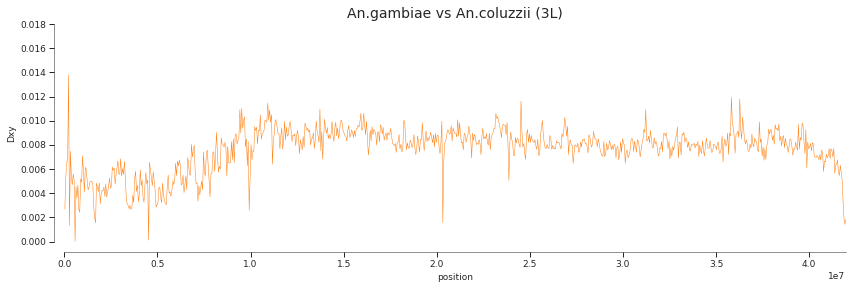

In [15]:
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5,  color=palette[1])
ax.set_xlim(0, pos.max())
ax.set_title(('An.gambiae vs An.coluzzii (3L)'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)

-------------------------------

## Dxy and Pi between <i>An.gambiae</i> and <i>An.coluzzii</i> populations

In [16]:
pi_gam, windows_gam, n_bases_gam, counts_gam = allel.windowed_diversity(pos, ac_subpops['agam'], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)

In [17]:
pi_col, windows_col, n_bases_col, counts_col = allel.windowed_diversity(pos, ac_subpops['acol'], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)

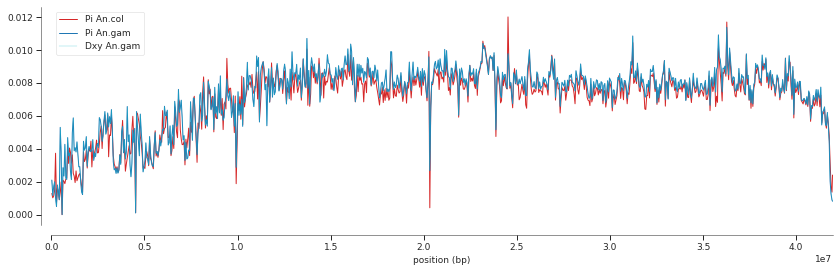

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

x1 = np.mean(windows_col[n_bases >= min_n_bases], axis=1)
y1 = pi_col[n_bases >= min_n_bases]
plt.plot(x1, y1, lw=1, label = "Pi An.col", color=palette[3]) 


x2 = np.mean(windows_gam[n_bases >= min_n_bases], axis=1)
y2 = pi_gam[n_bases >= min_n_bases]
plt.plot(x2, y2, lw=1, label = "Pi An.gam", color=palette[0]) 

x3 = np.mean(windows[n_bases >= min_n_bases], axis=1)
y3 = dxy[n_bases >= min_n_bases]
plt.plot(x2, y2, lw=.25, label = "Dxy An.gam", color=palette[9]) 

sns.despine(ax=ax, offset=10)
ax.set_xlim(0, pos.max())
ax.set_xlabel('position (bp)')
#ax.set_ylim(0,0.018)
sns.despine(ax=ax, offset=10)

# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show()

-----------------------------------------

## Perform Dxy and pi all over the chromosomes

In [19]:
chromosomes = ['3R']

In [ ]:
for chrom in chromosomes:
            

            metadata = pd.read_csv("samples.meta2.txt", sep=",")
            pop_selection = metadata.species.isin({'acol', 'agam'}).values
            pop_subset = metadata[pop_selection]
            grp = pop_subset.groupby("species")
            grp_indices = grp.indices
            genotypes = allel.GenotypeChunkedArray(calldata_hap_phase2[chrom]["calldata/GT"])
            geno_subset = genotypes.subset(sel1=pop_selection)
            pos = allel.SortedIndex(calldata_hap_phase2[chrom]['variants']['POS'][:])
            ac_subpops = geno_subset.count_alleles_subpops(grp_indices)
            is_accessible = accessibility[chrom]['is_accessible'][:]

            
            # run Dxy test
            dxy, windows, n_bases, counts = allel.windowed_divergence(pos, allel.AlleleCountsArray(ac_subpops[0]), allel.AlleleCountsArray(ac_subpops[1]), 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                                    is_accessible=is_accessible
                                                             )    
            pi_gam, windows_gam, n_bases_gam, counts_gam = allel.windowed_diversity(pos, ac_subpops[0], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)
            pi_col, windows_col, n_bases_col, counts_col = allel.windowed_diversity(pos, ac_subpops[1], size=50000, start=1, stop=pos.max(), is_accessible=is_accessible)
            fig, ax = plt.subplots(figsize=(14, 4))

            x1 = np.mean(windows_col[n_bases >= min_n_bases], axis=1)
            y1 = pi_col[n_bases >= min_n_bases]
            plt.plot(x1, y1, lw=1, label = "Pi An.col", color=palette[3]) 


            x2 = np.mean(windows_gam[n_bases >= min_n_bases], axis=1)
            y2 = pi_gam[n_bases >= min_n_bases]
            plt.plot(x2, y2, lw=1, label = "Pi An.gam", color=palette[0]) 

            x3 = np.mean(windows[n_bases >= min_n_bases], axis=1)
            y3 = dxy[n_bases >= min_n_bases]
            plt.plot(x2, y2, lw=.25, label = "Dxy An.gam", color=palette[9]) 

            sns.despine(ax=ax, offset=10)
            ax.set_xlim(0, pos.max())
            ax.set_xlabel('position (bp)')
            #ax.set_ylim(0,0.018)
            sns.despine(ax=ax, offset=10)

            # show a legend on the plot 
            plt.legend() 

            # function to show the plot 
            plt.show()